In [1]:
import os
os.chdir('/home/mohsen/projects/cpa/')
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import cpa
import scanpy as sc

Global seed set to 0


In [3]:
sc.settings.set_figure_params(dpi=100)

In [4]:
data_path = '/home/mohsen/projects/cpa/datasets/Norman2019_prep_new.h5ad'

In [5]:
adata = sc.read(data_path)
adata

AnnData object with n_obs × n_vars = 108497 × 5000
    obs: 'cov_drug_dose_name', 'dose_val', 'control', 'condition', 'guide_identity', 'drug_dose_name', 'cell_type', 'split', 'split1', 'split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10', 'split11', 'split12', 'split13', 'split14', 'split15', 'split16', 'split17', 'split18', 'split19', 'split20', 'split21', 'split22', 'split23', 'split24', 'split25'
    var: 'gene_symbols', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'rank_genes_groups_cov'
    layers: 'counts'

In [6]:
cpa.CPA.setup_anndata(adata, 
                      drug_key='condition', 
                      dose_key='dose_val',
                      control_key='control',
                      categorical_covariate_keys=['cell_type'],
                      combinatorial=True,
                     )

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             


/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


INFO     Successfully registered anndata object containing 108497 cells, 5000 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 108497/108497 [00:12<00:00, 8627.88it/s]


In [7]:
ae_hparams = {'adversary_depth': 2,
              'adversary_width': 128,
              'autoencoder_depth': 5,
              'autoencoder_width': 512,
              'dosers_depth': 3,
              'dosers_width': 64,
              'use_batch_norm': False,
              'use_layer_norm': True,
              'dropout_rate': 0.0,
              'variational': False,
              'seed': 30,
              }

trainer_params = {
    'n_epochs_warmup': 0,
    'adversary_lr': 1.5004133752248513e-04,
    'adversary_steps': 3,
    'adversary_wd': 4.3410565573508714e-05,
    'autoencoder_lr': 0.001734261293555584,
    'autoencoder_wd': 2.2700294383591616e-07,
    'dosers_lr': 0.0007022363227033381,
    'dosers_wd': 6.249509305603141e-06,
    'penalty_adversary': 0.013702812231919399,
    'reg_adversary': 2.02272482876072,
    'step_size_lr': 45,
}

In [8]:
model = cpa.CPA(adata=adata, 
                n_latent=128,
                loss_ae='gauss',
                doser_type='logsigm',
                split_key='split',
                **ae_hparams,
               )

/home/mohsen/projects/cpa/cpa/_model.py:454: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Global seed set to 30


In [9]:
model.train(max_epochs=1,
            use_gpu=True, 
            batch_size=1024,
            early_stopping=True,
            plan_kwargs=trainer_params,
            early_stopping_patience=15,
            check_val_every_n_epoch=20,
            save_path='/home/mohsen/projects/cpa/lightning_logs/Norman2019_prep_new/',
           )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name   | Type      | Params
-------------------------------------
0 | module | CPAModule | 10.0 M
-------------------------------------
10.0 M    Trainable params
0         Non-trainable params
10.0 M    Total params
39.896    Total estimated model params size (MB)


Epoch 1/1: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.24s/it, recon=-.494, adv_loss=0.663]


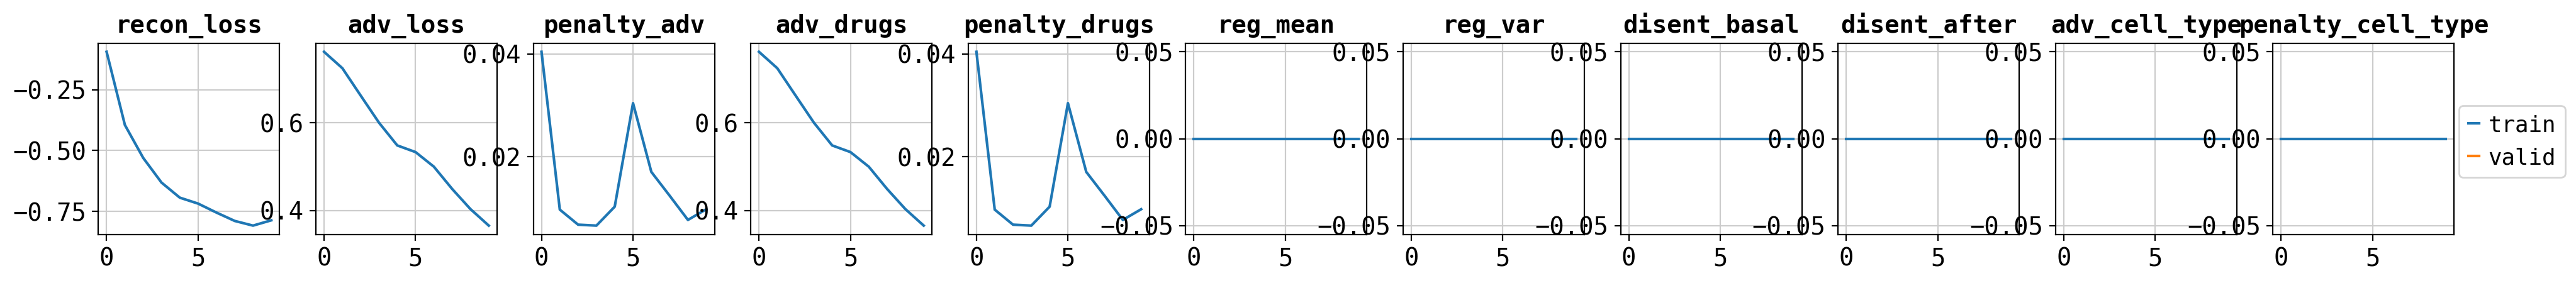

In [11]:
cpa.pl.plot_history(model)

In [10]:
cpa_api = cpa.ComPertAPI(adata, model)

In [11]:
cpa_plots = cpa.pl.CompertVisuals(cpa_api, fileprefix=None)

In [12]:
cpa_api.compute_comb_emb(thrh=30)

In [13]:
adata.obs['cell_type'].unique()

['A549']
Categories (1, object): ['A549']

In [17]:
adata.obs['condition'].unique()

['ctrl', 'TSC22D1+ctrl', 'KLF1+MAP2K6', 'CEBPE+RUNX1T1', 'MAML2+ctrl', ..., 'SNAI1+ctrl', 'PLK4+STIL', 'ZBTB10+ELMSAN1', 'CDKN1C+ctrl', 'C3orf72+FOXL2']
Length: 284
Categories (284, object): ['AHR+FEV', 'AHR+KLF1', 'AHR+ctrl', 'ARID1A+ctrl', ..., 'ZC3HAV1+HOXC13', 'ZC3HAV1+ctrl', 'ZNF318+FOXL2', 'ZNF318+ctrl']

In [13]:
import pandas as pd

In [17]:
# construct prediction annadata
subset = adata[adata.obs['cell_type'] == 'A549'].copy()
genes_control = subset[subset.obs['condition'] == 'ctrl'].copy()

df = pd.DataFrame({'condition': ['TSC22D1+ctrl'] + ['KLF1+MAP2K6'], 
                   'dose_val': ['1+1'] + ['1+1'], 
                   'cell_type': ['A549']*2})

pred = cpa_api.predict(genes_control.X.toarray(), df)  # normally would put `sample=True` here
pred.obs['cov_drug_dose_name'] = pred.obs['cell_type'].astype(str) + '_' + pred.obs['condition'].astype(str) + '_' + pred.obs['dose_val'].astype(str)
pred.obs['cov_drug_dose_name'] = pred.obs['cov_drug_dose_name'].astype('category')
pred

INFO     .obs[_scvi_batch] not found in target, assuming every cell is same category         
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'drugs_doses', 'cell_type']        
INFO     Successfully registered anndata object containing 8907 cells, 5000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


INFO     .obs[_scvi_batch] not found in target, assuming every cell is same category         
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'drugs_doses', 'cell_type']        
INFO     Successfully registered anndata object containing 8907 cells, 5000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)
/home/mohsen/projects/cpa/cpa/_model.py:454: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:801: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


AnnData object with n_obs × n_vars = 17814 × 5000
    obs: 'condition', 'dose_val', 'cell_type', 'uncertainty_cosine', 'uncertainty_euclidean', 'closest_cond_cosine', 'closest_cond_euclidean', 'cov_drug_dose_name'
    layers: 'variance'

In [18]:
adata.obs['cov_drug_dose_name'].unique()

['A549_ctrl_1', 'A549_TSC22D1+ctrl_1+1', 'A549_KLF1+MAP2K6_1+1', 'A549_CEBPE+RUNX1T1_1+1', 'A549_MAML2+ctrl_1+1', ..., 'A549_SNAI1+ctrl_1+1', 'A549_PLK4+STIL_1+1', 'A549_ZBTB10+ELMSAN1_1+1', 'A549_CDKN1C+ctrl_1+1', 'A549_C3orf72+FOXL2_1+1']
Length: 284
Categories (284, object): ['A549_AHR+FEV_1+1', 'A549_AHR+KLF1_1+1', 'A549_AHR+ctrl_1+1', 'A549_ARID1A+ctrl_1+1', ..., 'A549_ctrl+UBASH3B_1+1', 'A549_ctrl+ZBTB1_1+1', 'A549_ctrl+ZBTB25_1+1', 'A549_ctrl_1']

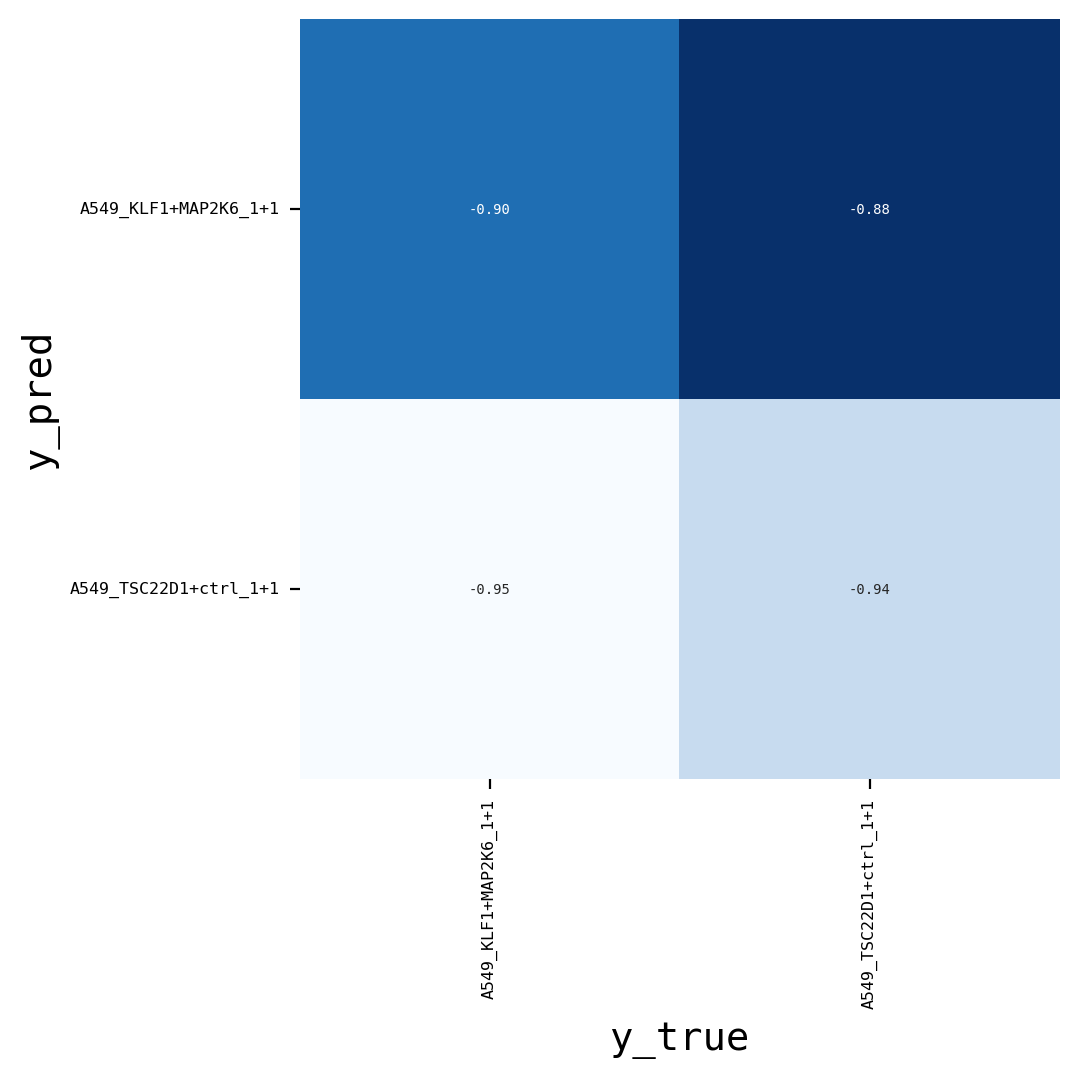

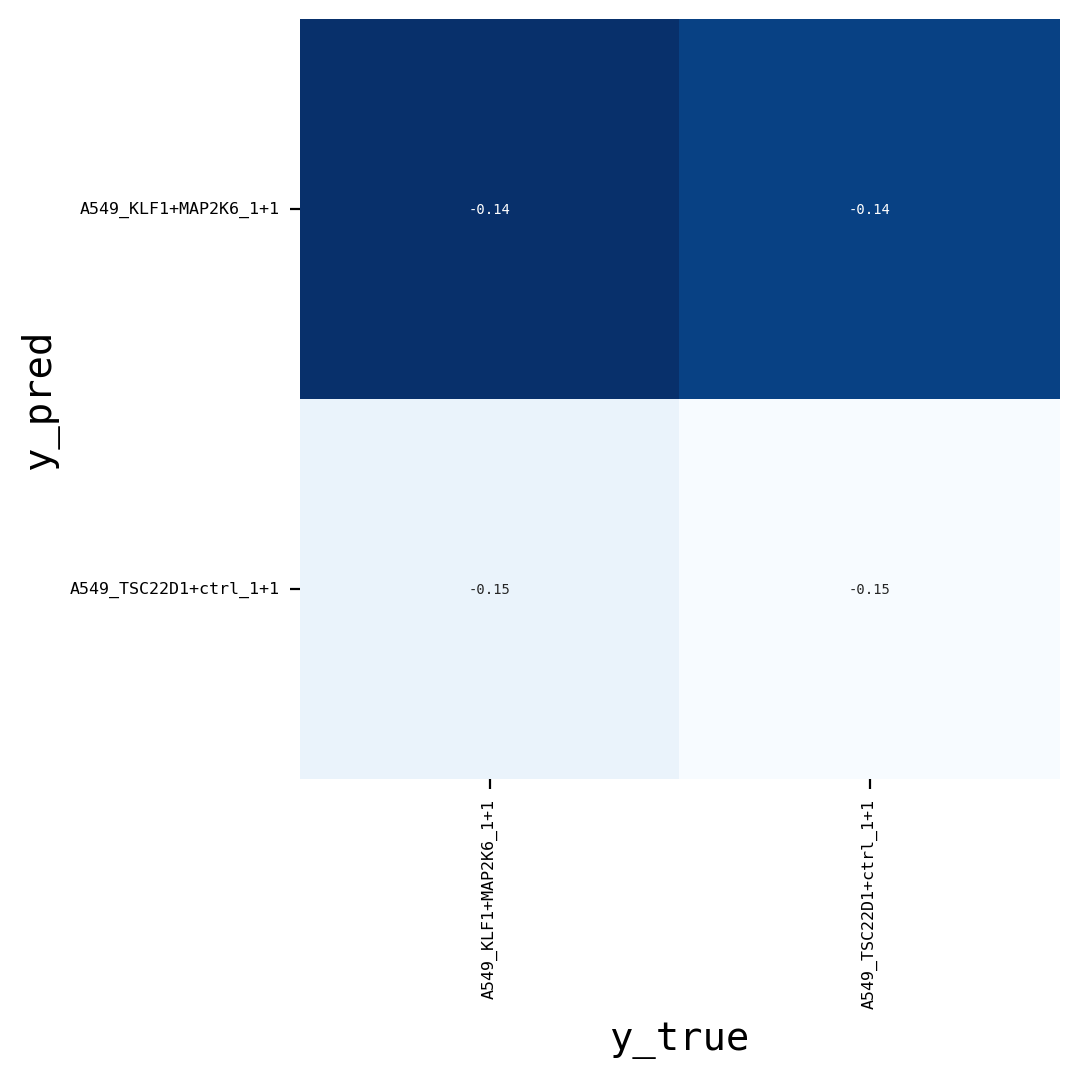

In [19]:
cpa.pl.plot_r2_matrix(pred, adata)

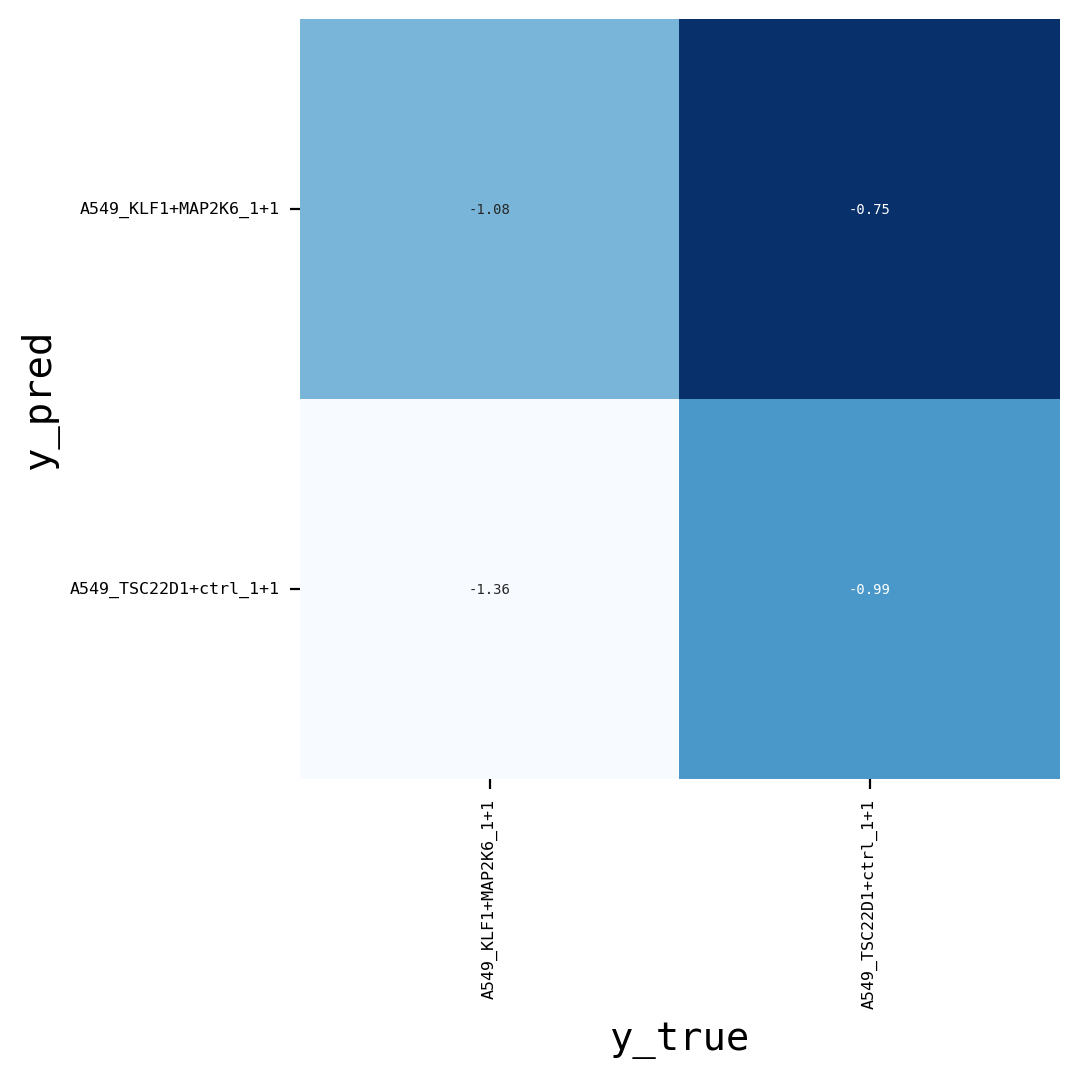

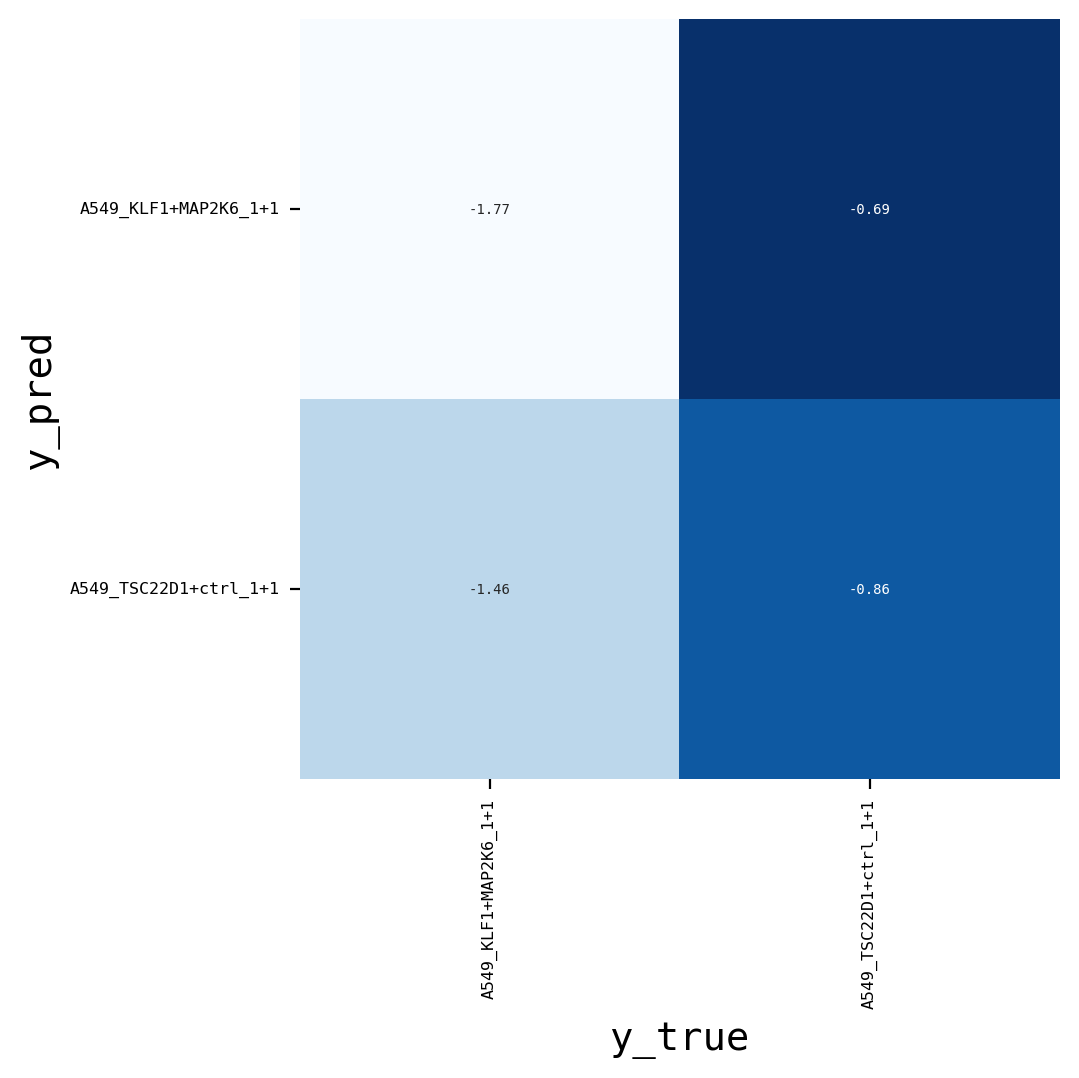

In [20]:
cpa.pl.plot_r2_matrix(pred, adata, adata.uns['rank_genes_groups_cov'])

In [23]:
de_dict = adata[adata.obs.split == 'train'].uns['rank_genes_groups_cov']
de_dict = {k: adata.var_names for k, v in de_dict.items()}

In [21]:
pred_adata = pred.concatenate(adata, batch_key='source', batch_categories=['pred', 'true'])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'condition' as categorical
/home/mohsen/miniconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of

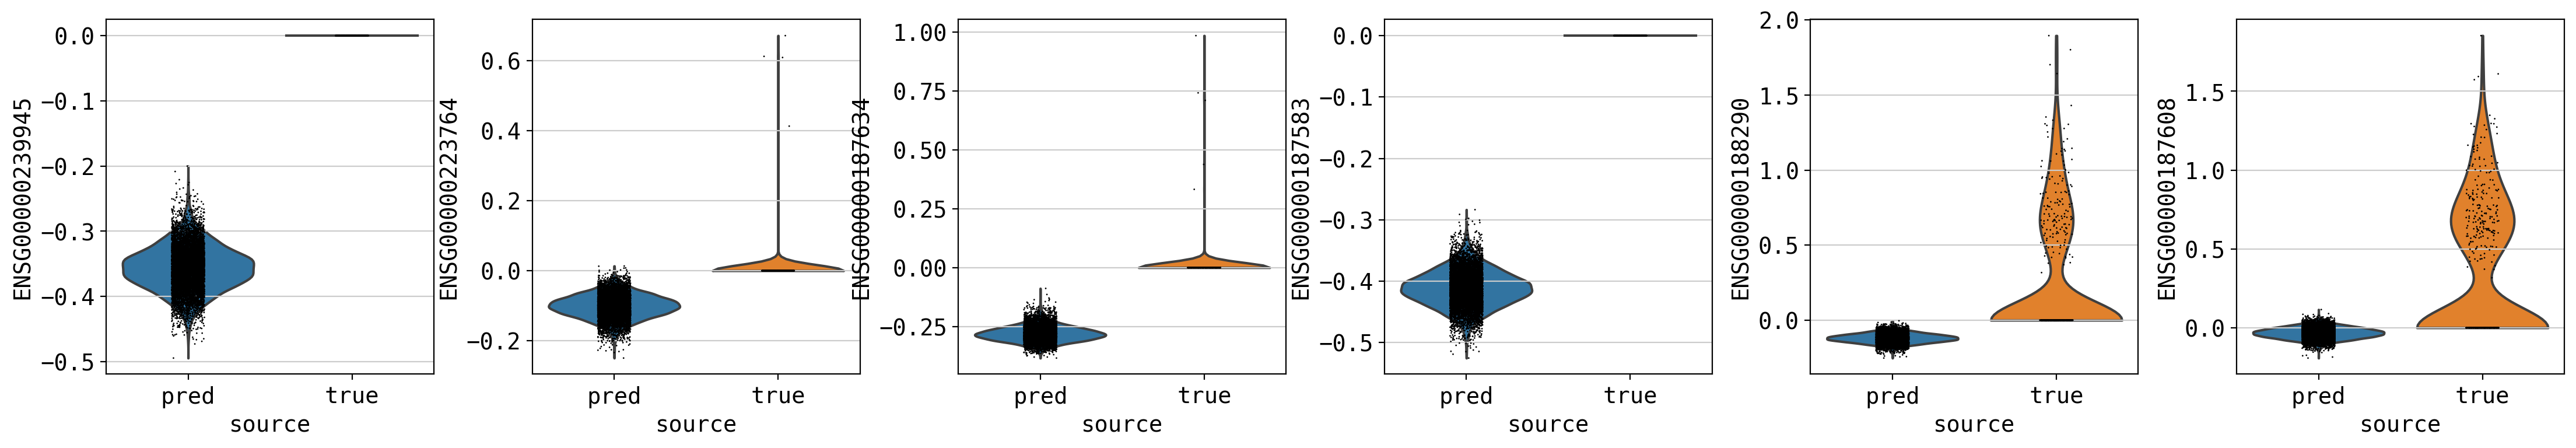

In [24]:
drug_name = 'TSC22D1+ctrl'
sc.pl.violin(
    pred_adata[pred_adata.obs.condition == drug_name],
    keys=de_dict[f'A549_{drug_name}_1+1'][:6],
    groupby='source')